<a href="https://colab.research.google.com/github/NaufalNurFahriza/Proyek-Klasifikasi-Gambar-Dicoding/blob/main/Submission_Akhir_Klasifikasi_Gambar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyek Klasifikasi Gambar: https://www.kaggle.com/datasets/vencerlanz09/agricultural-pests-image-dataset
- **Nama:** Naufal Nur Fahriza
- **Email:** naufalnurfahriza@gmail.com
- **ID Dicoding:** NurFahriza

## Import Semua Packages/Library yang Digunakan

In [ ]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


## Data Preparation

### Data Loading

In [3]:
# Import module yang disediakan google colab untuk kebutuhan upload file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"naufalnurfahriza","key":"ec6f7ab7dabebc9fd0600384aa1880de"}'}

In [4]:
!pip install -q kaggle

In [5]:
# Setup credential kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
# Download dataset DermNet
!kaggle datasets download -d vencerlanz09/agricultural-pests-image-dataset

Dataset URL: https://www.kaggle.com/datasets/vencerlanz09/agricultural-pests-image-dataset
License(s): copyright-authors
 82% 84.0M/102M [00:00<00:00, 204MB/s]
100% 102M/102M [00:00<00:00, 180MB/s] 


In [7]:
# Unzip dataset
!unzip -q agricultural-pests-image-dataset.zip -d pests_data

In [8]:
# Verifikasi dataset
print("Daftar folder:")
print(os.listdir("pests_data"))
print("\nJumlah gambar per kategori:")
for folder in os.listdir("pests_data"):
    folder_path = os.path.join("pests_data", folder)
    if os.path.isdir(folder_path):
        print(f"{folder}: {len(os.listdir(folder_path))} gambar")

Daftar folder:
['ants', 'weevil', 'moth', 'grasshopper', 'catterpillar', 'snail', 'wasp', 'slug', 'beetle', 'earwig', 'bees', 'earthworms']

Jumlah gambar per kategori:
ants: 499 gambar
weevil: 485 gambar
moth: 497 gambar
grasshopper: 485 gambar
catterpillar: 434 gambar
snail: 500 gambar
wasp: 498 gambar
slug: 391 gambar
beetle: 416 gambar
earwig: 466 gambar
bees: 500 gambar
earthworms: 323 gambar


### Data Preprocessing

#### Split Dataset

In [9]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath = 'pests_data/'

file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

df = pd.DataFrame({
    "path": full_path,
    "file_name": file_name,
    "labels": labels
})

print("\nDistribusi data awal:")
print(df.groupby(['labels']).size())


Distribusi data awal:
labels
ants            499
bees            500
beetle          416
catterpillar    434
earthworms      323
earwig          466
grasshopper     485
moth            497
slug            391
snail           500
wasp            498
weevil          485
dtype: int64


In [10]:
# Variabel yang digunakan pada pemisahan data ini dimana variabel x = data path dan y = data labels
X = df['path']
y = df['labels']

# Split ke train dan test (80:20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

In [11]:
# Menyatukan kedalam masing-masing dataframe
df_tr = pd.DataFrame({'path': X_train, 'labels': y_train, 'set': 'train'})
df_te = pd.DataFrame({'path': X_test, 'labels': y_test, 'set': 'test'})

In [12]:
# Print hasil diatas untuk melihat panjang size data training dan testing
print('\ntrain size:', len(df_tr))
print('test size :', len(df_te))


train size: 4395
test size : 1099


In [13]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('\nDistribusi setelah split:')
print(df_all.groupby(['set', 'labels']).size())


Distribusi setelah split:
set    labels      
test   ants            100
       bees            100
       beetle           83
       catterpillar     87
       earthworms       65
       earwig           93
       grasshopper      97
       moth             99
       slug             78
       snail           100
       wasp            100
       weevil           97
train  ants            399
       bees            400
       beetle          333
       catterpillar    347
       earthworms      258
       earwig          373
       grasshopper     388
       moth            398
       slug            313
       snail           400
       wasp            398
       weevil          388
dtype: int64


In [14]:
# Buat struktur folder baru
dataset_path = "pests_dataset_final/"
os.makedirs(dataset_path, exist_ok=True)

In [15]:
# Salin gambar ke folder baru sesuai set dan label
for index, row in tq(df_all.iterrows(), total=len(df_all)):
    file_path = row['path']
    label = row['labels']
    subset = row['set']

    dest_folder = os.path.join(dataset_path, subset, label)
    os.makedirs(dest_folder, exist_ok=True)

    file_name = os.path.basename(file_path)
    dest_path = os.path.join(dest_folder, file_name)

    if not os.path.exists(dest_path):
        shutil.copy2(file_path, dest_path)

  0%|          | 0/5494 [00:00<?, ?it/s]

### Image Data Generator

## Modelling

In [18]:
# Define training and test directories
TRAIN_DIR = "pests_dataset_final/train/"
TEST_DIR = "pests_dataset_final/test/"

class_names = os.listdir(TRAIN_DIR)

print("📊 Jumlah gambar per kelas:")
print("\nTraining Set:")
for cls in class_names:
    cls_path = os.path.join(TRAIN_DIR, cls)
    num_images = len(os.listdir(cls_path))
    print(f"  {cls}: {num_images}")

print("\nTest Set:")
for cls in class_names:
    cls_path = os.path.join(TEST_DIR, cls)
    num_images = len(os.listdir(cls_path))
    print(f"  {cls}: {num_images}")

📊 Jumlah gambar per kelas:

Training Set:
  ants: 399
  weevil: 388
  moth: 398
  grasshopper: 388
  catterpillar: 347
  snail: 400
  wasp: 398
  slug: 313
  beetle: 333
  earwig: 373
  bees: 400
  earthworms: 258

Test Set:
  ants: 100
  weevil: 97
  moth: 99
  grasshopper: 97
  catterpillar: 87
  snail: 100
  wasp: 100
  slug: 78
  beetle: 83
  earwig: 93
  bees: 100
  earthworms: 65


In [19]:
# Buat objek ImageDataGenerator yang menormalkan gambar dan menyertakan validation split
datagen = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1. / 255)

# Generator untuk training set
train_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    batch_size=32,
    target_size=(224, 224),
    color_mode="rgb",
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Generator untuk validation set
validation_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    batch_size=32,
    target_size=(224, 224),
    color_mode="rgb",
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Generator untuk test set
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    batch_size=1,
    target_size=(224, 224),
    color_mode="rgb",
    class_mode='categorical',
    shuffle=False
)

Found 3522 images belonging to 12 classes.
Found 873 images belonging to 12 classes.
Found 1099 images belonging to 12 classes.


In [36]:
# Define Transfer Learning Model with Sequential
# Define the model architecture
def create_model():
    # Load MobileNetV2 as base model
    base_model = MobileNetV2(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet',
        pooling=None
    )

    # Freeze the base model
    base_model.trainable = False

    # Build custom head
    model = Sequential([
        base_model,
        Dropout(0.2),
        Conv2D(32, (3,3), padding='same', activation='relu'),
        GlobalAveragePooling2D(),
        Dense(len(class_names), activation='softmax')  # Dynamic output units based on class count
    ])

    # Learning rate schedule
    initial_learning_rate = 0.001
    lr_schedule = ExponentialDecay(
        initial_learning_rate,
        decay_steps=1000,
        decay_rate=0.9,
        staircase=True
    )

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=lr_schedule),
        loss='categorical_crossentropy',
        metrics=['accuracy',
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')]
    )

    return model

# Create model
model = create_model()
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 7, 7, 1280)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 7, 7, 32)            │         368,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 32)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 12)                  │             396 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,627,052 (10.02 MB)

 Trainable params: 369,068 (1.41 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [37]:
# Define callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]

In [39]:
# Calculate class weights (important for imbalanced datasets)
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=30,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

# Load the best model
model.load_weights('best_model.h5')

Epoch 1/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.8796 - loss: 0.3892 - precision: 0.9144 - recall: 0.8505
Epoch 1: val_accuracy improved from 0.81713 to 0.81944, saving model to best_model.h5


110/110 ━━━━━━━━━━━━━━━━━━━━ 59s 541ms/step - accuracy: 0.8796 - loss: 0.3892 - precision: 0.9144 - recall: 0.8505 - val_accuracy: 0.8194 - val_loss: 0.6090 - val_precision: 0.8779 - val_recall: 0.7905 - learning_rate: 0.0010
Epoch 2/30
  1/110 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9688 - loss: 0.1293 - precision: 1.0000 - recall: 0.9062

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.81944 to 0.82176, saving model to best_model.h5


110/110 ━━━━━━━━━━━━━━━━━━━━ 21s 189ms/step - accuracy: 0.9688 - loss: 0.1293 - precision: 1.0000 - recall: 0.9062 - val_accuracy: 0.8218 - val_loss: 0.5776 - val_precision: 0.8794 - val_recall: 0.7847 - learning_rate: 0.0010
Epoch 3/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.8844 - loss: 0.3370 - precision: 0.9215 - recall: 0.8549
Epoch 3: val_accuracy did not improve from 0.82176
110/110 ━━━━━━━━━━━━━━━━━━━━ 82s 745ms/step - accuracy: 0.8844 - loss: 0.3371 - precision: 0.9215 - recall: 0.8549 - val_accuracy: 0.8009 - val_loss: 0.7385 - val_precision: 0.8407 - val_recall: 0.7697 - learning_rate: 0.0010
Epoch 4/30
  1/110 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.8438 - loss: 0.3580 - precision: 0.8387 - recall: 0.8125
Epoch 4: val_accuracy did not improve from 0.82176
110/110 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - accuracy: 0.8438 - loss: 0.3580 - precision: 0.8387 - recall: 0.8125 - val_accuracy: 0.8032 - val_loss: 0.6903 - val_precision: 0.8571 - val_recall: 0.

TypeError: This optimizer was created with a `LearningRateSchedule` object as its `learning_rate` constructor argument, hence its learning rate is not settable. If you need the learning rate to be settable, you should instantiate the optimizer with a float `learning_rate` argument.

## Evaluasi dan Visualisasi

In [1]:
# Evaluasi di test set
print("\nEvaluating on test set...")
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


Evaluating on test set...


NameError: name 'model' is not defined

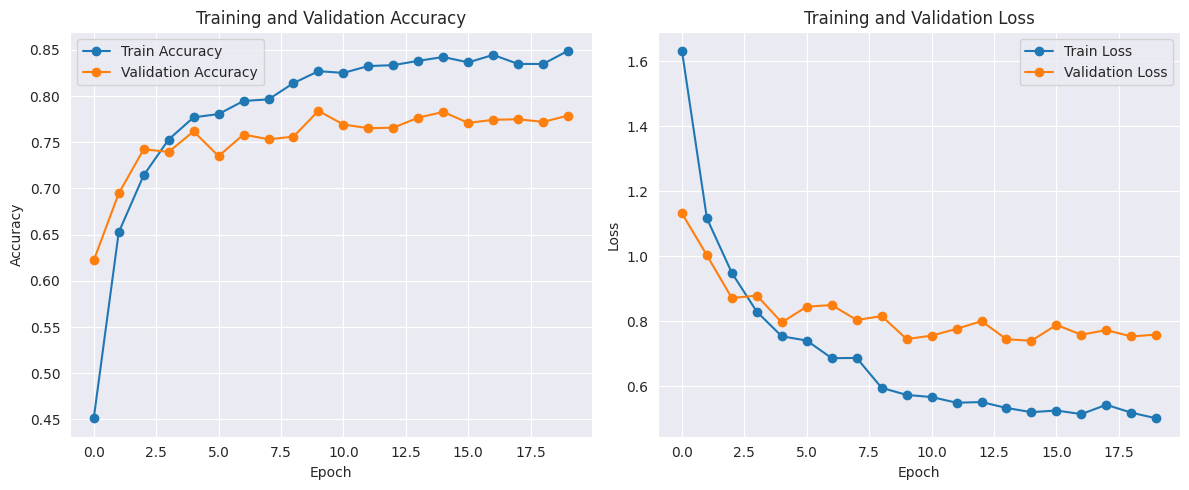

In [ ]:
# Plot grafik akurasi & loss
plt.figure(figsize=(12,5))

# Plot Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
# Plot Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Prediksi data test
test_generator.reset()  # pastikan tidak acak
predictions = model.predict(test_generator, verbose=1)

# Ambil label prediksi dan label asli
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# Label kelas
class_labels = list(test_generator.class_indices.keys())

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

2200/2200 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step
Classification Report:
               precision    recall  f1-score   support

    apple_pie       0.61      0.65      0.63       216
   cheesecake       0.86      0.80      0.83       214
chicken_curry       0.65      0.83      0.73       166
 french_fries       0.84      0.90      0.87       178
   fried_rice       0.91      0.81      0.86       207
    hamburger       0.80      0.85      0.82       220
      hot_dog       0.84      0.83      0.83       214
    ice_cream       0.84      0.83      0.83       203
     omelette       0.75      0.67      0.71       207
        pizza       0.88      0.90      0.89       188
        sushi       0.88      0.78      0.83       187

     accuracy                           0.80      2200
    macro avg       0.81      0.80      0.80      2200
 weighted avg       0.81      0.80      0.80      2200





---



## Konversi Model

## Inference (Optional)